In [71]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
import requests
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [72]:
n_samples = 1000

# create circles
X, y = make_circles(n_samples, 
                    noise=0.03,
                    random_state=42)

In [73]:
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:, 1],
                        "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


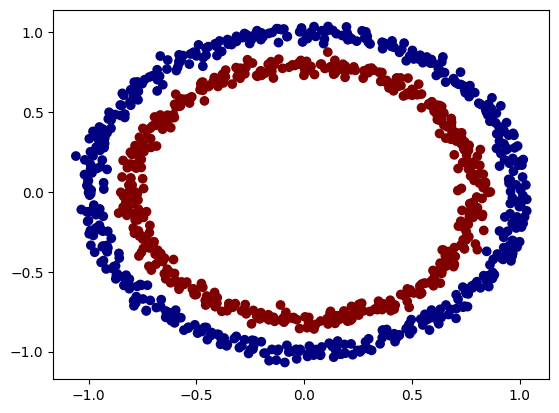

In [74]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='jet')

In [75]:
X.shape, y.shape

((1000, 2), (1000,))

In [76]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [77]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [78]:
from sklearn.model_selection import train_test_split


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Building a Model

In [80]:
class CircleModelV1(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # create 2 nn.Linear layers capable of handling shapes of the data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)


    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_2( self.layer_1(x))

    #     self.two_linear_layers = nn.Sequential(
    #         nn.Linear(in_features=2, out_features=5),
    #         nn.Linear(in_features=5, out_features=1)
    #     )

    # def forward(self, x:torch.Tensor) -> torch.Tensor:
    #     return self.two_linear_layers(x)
    
# instantiate the model class and send it to gpu
model_0 = CircleModelV1().to(device)        

In [81]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [82]:

# replicate model using nn.Sequential

model_0 = nn.Sequential( # no need to create a forward method but still not recommended for a more complex forward propagation or layers
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [83]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [84]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(f'len of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}')
    print(f'len of test samples: {len(X_test)}, shape: {X_test.shape}')
    print("preds[:10]:\n", torch.round(untrained_preds[:10])) 
    print("labes[:10]:\n", y_test[:10])

len of predictions: 200, shape: torch.Size([200, 1])
len of test samples: 200, shape: torch.Size([200, 2])
preds[:10]:
 tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')
labes[:10]:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# Loss, Optimizer

* Loss  
Linear - MAE (mean absolute error) MSE (mean squared error)  
Cat - cross entrophy etc

10:00

In [85]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1) # built-in sigmoid actication function

"""
 ^ same as: 
     nn.Sequential(  
        nn.Sigmoid(),  
        nn.BCELoss()  
    ) 
""" 

'\n ^ same as: \n     nn.Sequential(  \n        nn.Sigmoid(),  \n        nn.BCELoss()  \n    ) \n'

In [86]:
# calculate accuracy

def accuracy_fn(y_true, y_pred) -> float: 
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [87]:
# view logits
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [88]:
# use sigmoid to logit to make a round() logit (prediction probability) and compare it into y_test (label)

y_pred_probs = torch.sigmoid(y_logits)
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')

In [89]:
# prediction probability values rounding rulw
# threshold = 0.5 (class 1) default value 

# find the predicted labels
y_preds = torch.round(y_pred_probs)

# in full
y_pred_labels=  torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze() # remove extra dimensions

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

# logits -> pre probs -> pred labels

In [90]:
# training, test loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    ## Training
    model_0.train()
    
    # forward propagation
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate the loss

    # loss = loss_fn(torch.sigmoid(y_logits), y_train) - this one if use bce for loss

    loss = loss_fn(y_logits, y_train) # bcelogitsloss expect bce(only) as an input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward() # back propagation
    optimizer.step() # gradient descent


    ## Testing    
    model_0.eval()
    with torch.inference_mode():
       # forward pass
       test_logits = model_0(X_test).squeeze()
       test_pred = torch.round(torch.sigmoid(test_logits))

       #calculate the loss
       test_loss = loss_fn(test_logits, y_test)
       test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print 

    if epoch % 10 == 0:
        print(f"epoch: {epoch}, acc: {acc:.2f} % | test loss: {test_loss:.5f}, test acc: {test_acc:.2f} %")

    

epoch: 0, acc: 51.88 % | test loss: 0.69440, test acc: 58.00 %
epoch: 10, acc: 51.25 % | test loss: 0.69305, test acc: 53.00 %
epoch: 20, acc: 51.62 % | test loss: 0.69254, test acc: 49.50 %
epoch: 30, acc: 51.12 % | test loss: 0.69236, test acc: 49.50 %
epoch: 40, acc: 50.88 % | test loss: 0.69232, test acc: 51.00 %
epoch: 50, acc: 50.25 % | test loss: 0.69234, test acc: 50.00 %
epoch: 60, acc: 50.00 % | test loss: 0.69239, test acc: 51.50 %
epoch: 70, acc: 50.25 % | test loss: 0.69246, test acc: 51.00 %
epoch: 80, acc: 49.88 % | test loss: 0.69254, test acc: 50.00 %
epoch: 90, acc: 49.88 % | test loss: 0.69262, test acc: 53.00 %


## make predictions and evaluate model

model not learning  
make visual to see the problem

In [91]:
# dowload helper functions if not yet downlaoded

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists")
else:
    print('Downloading helper_functions.py')
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with  open('helper_functions.py', 'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists


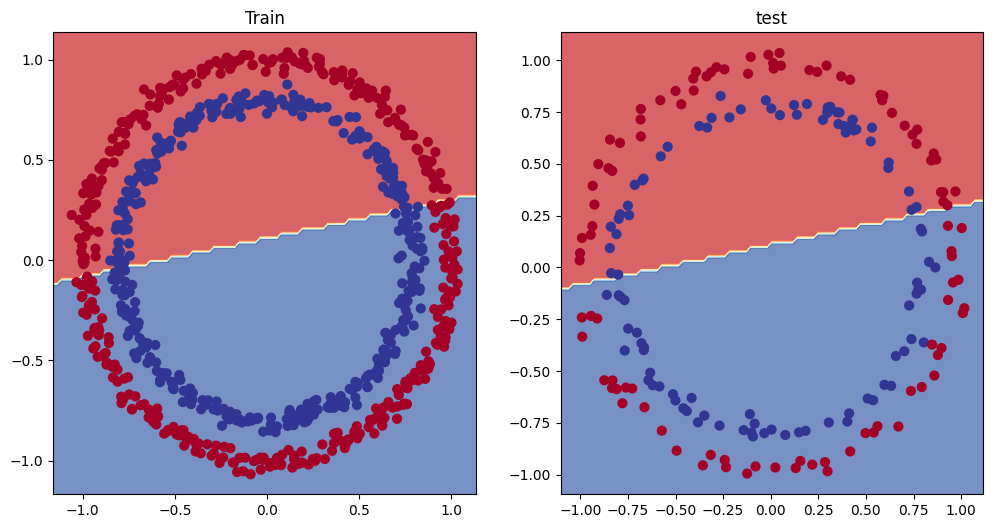

In [92]:
# plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

# for testing data
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)

# 11:07